In [2]:
import pandas as pd

weather = pd.read_csv("data1.csv")

In [3]:
weather

,DATE,PRCP,TEMP
0,2024-01-18 00:35:05,1,27.1
1,NaN,FALSE,FALSE
2,NaN,FALSE,FALSE
3,2024-01-18 00:35:10,1,27.1
4,NaN,FALSE,FALSE
...,...,...,...
16379,NaN,FALSE,FALSE
16380,NaN,FALSE,FALSE
16381,2024-01-18 08:13:43,1,25.3
16382,NaN,FALSE,FALSE


In [529]:
weather['TMAX'] = pd.to_numeric(weather['TMAX'], errors='coerce').astype('Int64')
weather['TMIN'] = pd.to_numeric(weather['TMIN'], errors='coerce').astype('Int64')

In [530]:
weather = weather.ffill()

In [531]:
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]
null_pct

STATION    0.0
NAME       0.0
PRCP       0.0
TMAX       0.0
TMIN       0.0
dtype: float64

In [532]:
valid_columns = weather.columns[null_pct < .05]

In [533]:
valid_columns

Index(['STATION', 'NAME', 'PRCP', 'TMAX', 'TMIN'], dtype='object')

In [534]:
weather = weather[valid_columns].copy()

In [535]:
weather.columns = weather.columns.str.lower()

In [536]:
weather

,station,name,prcp,tmax,tmin
DATE,,,,,
1/1/2003,VMM00048855,"DANANG INTERNATIONAL, VM",0.17,26,20
1/2/2003,VMM00048855,"DANANG INTERNATIONAL, VM",0.03,27,20
1/3/2003,VMM00048855,"DANANG INTERNATIONAL, VM",0.10,24,20
1/4/2003,VMM00048855,"DANANG INTERNATIONAL, VM",0.21,21,20
1/5/2003,VMM00048855,"DANANG INTERNATIONAL, VM",0.31,23,20
...,...,...,...,...,...
1/14/2024,VMM00048855,"DANANG INTERNATIONAL, VM",0.00,28,21
1/15/2024,VMM00048855,"DANANG INTERNATIONAL, VM",0.07,27,21
1/16/2024,VMM00048855,"DANANG INTERNATIONAL, VM",0.07,27,21


In [537]:
weather.apply(pd.isnull).sum()

station    0
name       0
prcp       0
tmax       0
tmin       0
dtype: int64

In [538]:
weather.apply(lambda x: (x == 9999).sum())

station    0
name       0
prcp       0
tmax       0
tmin       0
dtype: int64

In [539]:
weather.dtypes

station     object
name        object
prcp       float64
tmax         Int64
tmin         Int64
dtype: object

In [540]:
weather.index

Index(['1/1/2003', '1/2/2003', '1/3/2003', '1/4/2003', '1/5/2003', '1/6/2003',
       '1/7/2003', '1/8/2003', '1/9/2003', '1/10/2003',
       ...
       '1/9/2024', '1/10/2024', '1/11/2024', '1/12/2024', '1/13/2024',
       '1/14/2024', '1/15/2024', '1/16/2024', '1/17/2024', '1/18/2024'],
      dtype='object', name='DATE', length=7685)

In [541]:
weather.index = pd.to_datetime(weather.index)

In [542]:
weather.index.year.value_counts().sort_index()

DATE
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    362
2022    365
2023    365
2024     18
Name: count, dtype: int64

In [543]:
weather["target"] = weather.shift(-1)["tmax"]

In [544]:
weather

,station,name,prcp,tmax,tmin,target
DATE,,,,,,
2003-01-01,VMM00048855,"DANANG INTERNATIONAL, VM",0.17,26,20,27
2003-01-02,VMM00048855,"DANANG INTERNATIONAL, VM",0.03,27,20,24
2003-01-03,VMM00048855,"DANANG INTERNATIONAL, VM",0.10,24,20,21
2003-01-04,VMM00048855,"DANANG INTERNATIONAL, VM",0.21,21,20,23
2003-01-05,VMM00048855,"DANANG INTERNATIONAL, VM",0.31,23,20,22
...,...,...,...,...,...,...
2024-01-14,VMM00048855,"DANANG INTERNATIONAL, VM",0.00,28,21,27
2024-01-15,VMM00048855,"DANANG INTERNATIONAL, VM",0.07,27,21,27
2024-01-16,VMM00048855,"DANANG INTERNATIONAL, VM",0.07,27,21,27


In [545]:
weather = weather.ffill()

In [546]:
weather

,station,name,prcp,tmax,tmin,target
DATE,,,,,,
2003-01-01,VMM00048855,"DANANG INTERNATIONAL, VM",0.17,26,20,27
2003-01-02,VMM00048855,"DANANG INTERNATIONAL, VM",0.03,27,20,24
2003-01-03,VMM00048855,"DANANG INTERNATIONAL, VM",0.10,24,20,21
2003-01-04,VMM00048855,"DANANG INTERNATIONAL, VM",0.21,21,20,23
2003-01-05,VMM00048855,"DANANG INTERNATIONAL, VM",0.31,23,20,22
...,...,...,...,...,...,...
2024-01-14,VMM00048855,"DANANG INTERNATIONAL, VM",0.00,28,21,27
2024-01-15,VMM00048855,"DANANG INTERNATIONAL, VM",0.07,27,21,27
2024-01-16,VMM00048855,"DANANG INTERNATIONAL, VM",0.07,27,21,27


In [547]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

In [548]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]


In [549]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]

        model.fit(train[predictors], train["target"])

        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [550]:
predictions = backtest(weather, rr, predictors)

In [551]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(predictions["actual"], predictions["prediction"])

0.7445906908061539

In [552]:
predictions.sort_values("diff", ascending=False)

,actual,prediction,diff
DATE,,,
2013-04-06,27,38.613061,11.613061
2016-09-07,34,22.397238,11.602762
2015-05-28,39,28.542411,10.457589
2017-11-30,33,22.760440,10.23956
2021-10-12,26,35.510184,9.510184
...,...,...,...
2023-11-08,31,30.999649,0.000351
2013-08-09,33,33.000165,0.000165
2013-07-04,33,33.000165,0.000165


In [553]:
pd.Series(rr.coef_, index=predictors)

prcp    0.018433
tmax    0.909727
tmin    0.076447
dtype: float64

In [554]:
def pct_diff(old, new):
    return (new - old) / old

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"
    weather[label] = weather[col].rolling(horizon).mean()
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col])
    return weather

rolling_horizons = [3, 14]
for horizon in rolling_horizons:
    for col in ["tmax", "tmin", "prcp"]:
        weather = compute_rolling(weather, horizon, col)

In [555]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in ["tmax", "tmin", "prcp"]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys=False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day_of_year, group_keys=False).apply(expand_mean)

In [556]:
weather = weather.iloc[14:,:]
weather = weather.fillna(0)

In [557]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]

In [558]:
predictions = backtest(weather, rr, predictors)
mean_absolute_error(predictions["actual"], predictions["prediction"])

0.7827197695359664

In [559]:
mean_squared_error(predictions["actual"], predictions["prediction"])

1.6317016274906186

In [560]:
predictions.sort_values("diff", ascending=False)

,actual,prediction,diff
DATE,,,
2016-09-07,34,21.367272,12.632728
2013-04-06,27,37.234244,10.234244
2015-05-28,39,28.869546,10.130454
2017-11-30,33,23.275421,9.724579
2021-10-12,26,35.490627,9.490627
...,...,...,...
2022-03-12,28,27.999370,0.00063
2019-04-08,31,30.999586,0.000414
2015-02-27,27,27.000399,0.000399


In [561]:
weather.loc["2024-01-01": "2024-01-08"]

,station,name,prcp,tmax,tmin,target,rolling_3_tmax,rolling_3_tmax_pct,rolling_3_tmin,rolling_3_tmin_pct,...,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prcp,rolling_14_prcp_pct,month_avg_tmax,day_avg_tmax,month_avg_tmin,day_avg_tmin,month_avg_prcp,day_avg_prcp
DATE,,,,,,,,,,,,,,,,,,,,,
2024-01-01,VMM00048855,"DANANG INTERNATIONAL, VM",0.02,26,22,24,25.333333,0.026316,22.000000,0.0,...,19.857143,0.107914,0.693571,-0.971164,24.489264,24.409091,19.552147,20.181818,0.111887,0.179545
2024-01-02,VMM00048855,"DANANG INTERNATIONAL, VM",0.51,24,22,28,25.000000,-0.04,22.000000,0.0,...,19.785714,0.111913,0.730000,-0.301370,24.488515,24.409091,19.555896,19.681818,0.112496,0.092727
2024-01-03,VMM00048855,"DANANG INTERNATIONAL, VM",0.09,28,22,28,26.000000,0.076923,22.000000,0.0,...,19.928571,0.103943,0.642143,-0.859844,24.493884,25.045455,19.559633,19.954545,0.112462,0.068636
2024-01-04,VMM00048855,"DANANG INTERNATIONAL, VM",0.00,28,21,28,26.666667,0.05,21.666667,-0.030769,...,20.142857,0.042553,0.417143,-1.000000,24.499237,25.227273,19.561832,19.954545,0.112290,0.097727
2024-01-05,VMM00048855,"DANANG INTERNATIONAL, VM",0.00,28,21,27,28.000000,0.0,21.333333,-0.015625,...,20.357143,0.031579,0.242857,-1.000000,24.504573,25.272727,19.564024,20.181818,0.112119,0.125000
2024-01-06,VMM00048855,"DANANG INTERNATIONAL, VM",0.00,27,23,25,27.666667,-0.024096,21.666667,0.061538,...,20.785714,0.106529,0.220714,-1.000000,24.508371,25.045455,19.569254,20.500000,0.111948,0.172273
2024-01-07,VMM00048855,"DANANG INTERNATIONAL, VM",0.07,25,22,27,26.666667,-0.0625,22.000000,0.0,...,21.142857,0.040541,0.211429,-0.668919,24.509119,24.500000,19.572948,20.227273,0.111884,0.430455
2024-01-08,VMM00048855,"DANANG INTERNATIONAL, VM",0.02,27,21,28,26.333333,0.025316,22.000000,-0.045455,...,21.357143,-0.016722,0.212857,-0.906040,24.512898,24.045455,19.575114,19.909091,0.111745,0.137273


<Axes: xlabel='diff'>

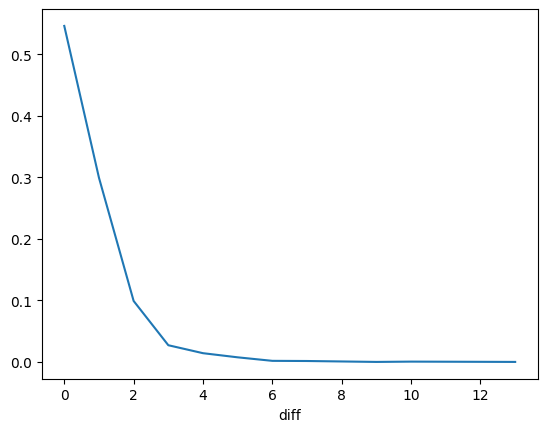

In [562]:
(predictions["diff"].round().value_counts().sort_index() / predictions.shape[0]).plot()

In [563]:
predictions

,actual,prediction,diff
DATE,,,
2013-01-12,26,25.102108,0.897892
2013-01-13,25,25.786691,0.786691
2013-01-14,26,24.769440,1.23056
2013-01-15,26,25.516720,0.48328
2013-01-16,26,25.581661,0.418339
...,...,...,...
2024-01-14,27,27.520237,0.520237
2024-01-15,27,26.653954,0.346046
2024-01-16,27,26.735515,0.264485


In [564]:
import joblib
# Instantiate the Ridge model
rr = Ridge(alpha=.1)

# Train the model on the entire dataset
rr.fit(weather[predictors], weather["target"])

# Save the model to a file
model_filename = "ridge_model.joblib"
joblib.dump(rr, model_filename)

['ridge_model.joblib']

In [565]:
model_filename = "ridge_model.joblib"
loaded_model = joblib.load(model_filename)
joblib.dump(model, 'ridge_model.pkl')
loaded_model1 = joblib.load('ridge_model.pkl')




In [567]:
# Lấy ngày cuối cùng trong tập dữ liệu
last_date = weather.index[-1]

# Tạo một DataFrame mới với cùng các đặc trưng như tập dữ liệu hiện tại cho 1 ngày tiếp theo
new_date = last_date + pd.Timedelta(days=1)
new_data = pd.DataFrame(index=[new_date], columns=predictors)

print(new_date)


# Lấy giá trị của các đặc trưng của ngày cuối cùng và gán chúng cho ngày mới
last_values = weather[predictors].iloc[-1]
new_data[predictors] = last_values.values
print(new_data[predictors])



# Đảm bảo rằng cột 'index' của 'new_data' là kiểu datetime
new_data.index = pd.to_datetime(new_data.index)


# Sử dụng mô hình Ridge để dự đoán cho ngày tiếp theo
prediction_for_next_day = loaded_model.predict(new_data[predictors])

# Làm tròn giá trị dự đoán và chuyển đổi chúng sang kiểu int64
prediction_for_next_day_int = prediction_for_next_day.round().astype('int')

# Tạo DataFrame mới chứa dự đoán và ngày tương ứng
prediction_df = pd.DataFrame(index=new_data.index, columns=["Prediction"])
prediction_df["Prediction"] = prediction_for_next_day_int

# Hiển thị dự đoán cho ngày tiếp theo


2024-01-19 00:00:00
            prcp  tmax  tmin  rolling_3_tmax  rolling_3_tmax_pct  \
2024-01-19   0.0  27.0  20.0            27.0                 0.0   

            rolling_3_tmin  rolling_3_tmin_pct  rolling_3_prcp  \
2024-01-19       20.666667           -0.032258        0.023333   

            rolling_3_prcp_pct  rolling_14_tmax  ...  rolling_14_tmin  \
2024-01-19                -1.0        27.142857  ...        21.428571   

            rolling_14_tmin_pct  rolling_14_prcp  rolling_14_prcp_pct  \
2024-01-19            -0.066667         0.021429                 -1.0   

            month_avg_tmax  day_avg_tmax  month_avg_tmin  day_avg_tmin  \
2024-01-19       24.554559     24.363636       19.600897     19.181818   

            month_avg_prcp  day_avg_prcp  
2024-01-19        0.110389      0.163636  

[1 rows x 21 columns]


In [ ]:
last_date = weather.index[-1]
print(last_date)


2024-01-18 00:00:00


In [ ]:
joblib.dump(model, 'ridge_model.pkl')


['ridge_model.pkl']

In [ ]:
print(prediction_df)



            Prediction
2024-01-19          27
